In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Generators.GA.TestGeneticAlgorithm import GeneticAlgorithm
from Generators.Optimizers.BayesianOptimization import BayesianOptimization
from Generators.Optimizers.HillClimbAlgorithm import HillClimbAlgorithm
from Generators.Optimizers.SimulatedAnnealing import SimulatedAnnealing
from Generators.Optimizers.TabuSearch import TabuSearch
from Generators.Optimizers.GuidedLocalSearch import GuidedLocalSearch
from Generators.Optimizers.MicrocanonicalAnnealing import MicrocanonicalAnnealing
from Generators.Optimizers.GradientDescent import GradientDescent

In [2]:
kwargs = {
    'cnn_model_path': 'Models/CNN_6_1_2.keras',
    'masked_sequence': 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG',
}
target_expressions = [0, 0.5, 1]

iterations = 3

optimizers = {
    'Genetic Algorithm': GeneticAlgorithm,
    'Bayesian Optimization': BayesianOptimization,
    'Hill Climb Algorithm': HillClimbAlgorithm,
    'Simulated Annealing': SimulatedAnnealing,
    'Tabu Search': TabuSearch,
    'Guided Local Search': GuidedLocalSearch,
    'Microcanonical Annealing' : MicrocanonicalAnnealing,
    'Gradient Descent': GradientDescent,
}

### Testing Each Optimizer
---

In [3]:
results = {
    'optimizer': [],
    'target_expression': [],
    'iteration': [],
    'prediction': [],
    'error': [],
    'prediction_history': [],
    'error_history': [],
}

for optimizer_name, optimizer_class in optimizers.items():
    for target_expression in target_expressions:
        for i in range(1, iterations+1):
            
            # if optimizer is deterministic, only run once
            if optimizer_name in ['Bayesian Optimization', 'Hill Climb Algorithm', 'Tabu Search'] and i > 1:
                continue

            print(f'{optimizer_name} | target_expression = {target_expression} | Iteration {i}', end='\r')
        
            convergence = []
            
            obj = optimizer_class(
                **kwargs,
                target_expression=target_expression,
                seed=i,
            )
            best_sequence, best_prediction, best_error = obj.run()
            prediction_history = obj.prediction_history

            if optimizer_name == 'Hill Climb Algorithm' and obj.early_stop:
                prediction_history.extend([best_prediction for _ in range(obj.max_iter - len(prediction_history))])

            prediction_history = np.array(prediction_history).flatten()
            error_history = np.array([abs(target_expression - pred) for pred in prediction_history])

            results['optimizer'].append(optimizer_name)
            results['target_expression'].append(target_expression)
            results['iteration'].append(i)
            results['prediction'].append(best_prediction)
            results['error'].append(best_error)
            results['prediction_history'].append(prediction_history)
            results['error_history'].append(error_history)

            print(' ' * 100, end='\r')
    print(f'{optimizer_name} Complete')

print('Evaluation Complete')

results_df = pd.DataFrame(results)
results_df.to_csv('Data/optimizer_evaluation_results.csv', index=False)
results_df.head()

Instructions for updating:
Use tf.identity with explicit device placement instead.
Genetic Algorithm Complete                                                                          


c:\Users\rsore\Documents\GitHub\e.-coli-promoter-prediction\Generators\CNN.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tensor_sequences = torch.tensor(


Bayesian Optimization Complete                                                                      
Hill Climb Algorithm Complete                                                                       
Simulated Annealing Complete                                                                        
Tabu Search Complete                                                                                
Guided Local Search Complete                                                                        
Microcanonical Annealing Complete                                                                   
Gradient Descent Complete                                                                           
Evaluation Complete


,optimizer,target_expression,iteration,prediction,error,prediction_history,error_history
0,Genetic Algorithm,0.0,1,0.136177,1.361773e-01,"[0.19980665, 0.19980665, 0.18855676, 0.1885567...","[0.19980664551258087, 0.19980664551258087, 0.1..."
1,Genetic Algorithm,0.0,2,0.130819,1.308187e-01,"[0.21075355, 0.20233881, 0.19498837, 0.1949437...","[0.21075354516506195, 0.2023388147354126, 0.19..."
2,Genetic Algorithm,0.0,3,0.121564,1.215643e-01,"[0.20536067, 0.1967421, 0.1959874, 0.1792827, ...","[0.20536066591739655, 0.19674210250377655, 0.1..."
3,Genetic Algorithm,0.5,1,0.500000,1.788139e-07,"[0.48508948, 0.48709917, 0.49418157, 0.4981302...","[0.014910519123077393, 0.012900829315185547, 0..."
4,Genetic Algorithm,0.5,2,0.500000,1.788139e-07,"[0.5017191, 0.5017191, 0.49910384, 0.49972004,...","[0.0017191171646118164, 0.0017191171646118164,..."


In [4]:
# Average each optimizer's results across iterations
def average_tests(df):
    def average_lists(series_of_lists):
        return np.mean(list(zip(*series_of_lists)), axis=1).tolist()

    grouped = df.groupby(['optimizer', 'target_expression'])

    return grouped.agg({
        'prediction': 'mean',
        'error': 'mean',
        'prediction_history': average_lists,
        'error_history': average_lists
    }).reset_index()

# Get the best test for each optimizer and target expression
def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]

        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)


In [5]:
results_df = average_tests(results_df)[['optimizer', 'target_expression', 'prediction', 'error']]
results_df.head(None)

,optimizer,target_expression,prediction,error
0,Bayesian Optimization,0.0,0.236981,2.369810e-01
1,Bayesian Optimization,0.5,0.504371,4.370689e-03
2,Bayesian Optimization,1.0,0.610389,3.896109e-01
3,Genetic Algorithm,0.0,0.129520,1.295201e-01
4,Genetic Algorithm,0.5,0.500000,5.364418e-07
5,Genetic Algorithm,1.0,0.869879,1.301209e-01
6,Gradient Descent,0.0,0.108582,1.085824e-01
7,Gradient Descent,0.5,0.500007,1.192093e-05
8,Gradient Descent,1.0,0.709602,2.903981e-01
9,Guided Local Search,0.0,0.281806,2.818061e-01


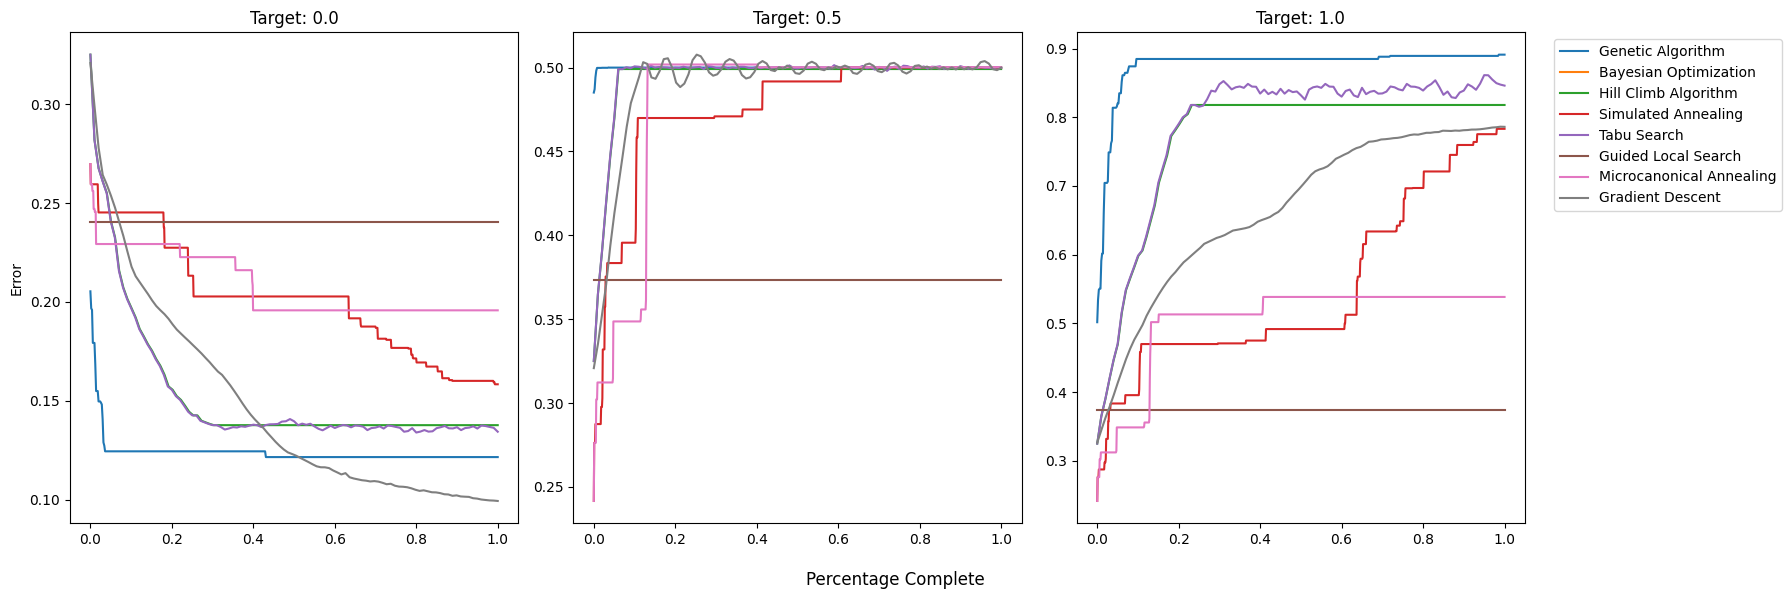

In [6]:
# -------------- Plot The Errors Over Time --------------

results_df = pd.DataFrame(results)
results_df = best_tests(results_df)

# Filter out Bayesian Optimization
results_df = results_df[results_df['optimizer'] != 'Bayesian Optimization']

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['percentage_complete'] = df_exploded['iteration'] / (group_sizes - 1)

optimizer_names = optimizers.keys()
palette = sns.color_palette("tab10", len(optimizer_names))
color_map = dict(zip(optimizer_names, palette))

target_expressions = df_exploded['target_expression'].unique()
fig, axes = plt.subplots(1, len(target_expressions), figsize=(18, 6))

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['percentage_complete'],
                group['prediction_history'],
                color=color_map[optimizer],
                label=optimizer
            )
    ax.set_title(f'Target: {target_expr}')

axes[0].set_ylabel('Error')
fig.supxlabel("Percentage Complete")

handles = []
labels = []
for optimizer in optimizer_names:
    handles.append(plt.Line2D([], [], color=color_map[optimizer], label=optimizer))
    labels.append(optimizer)

handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


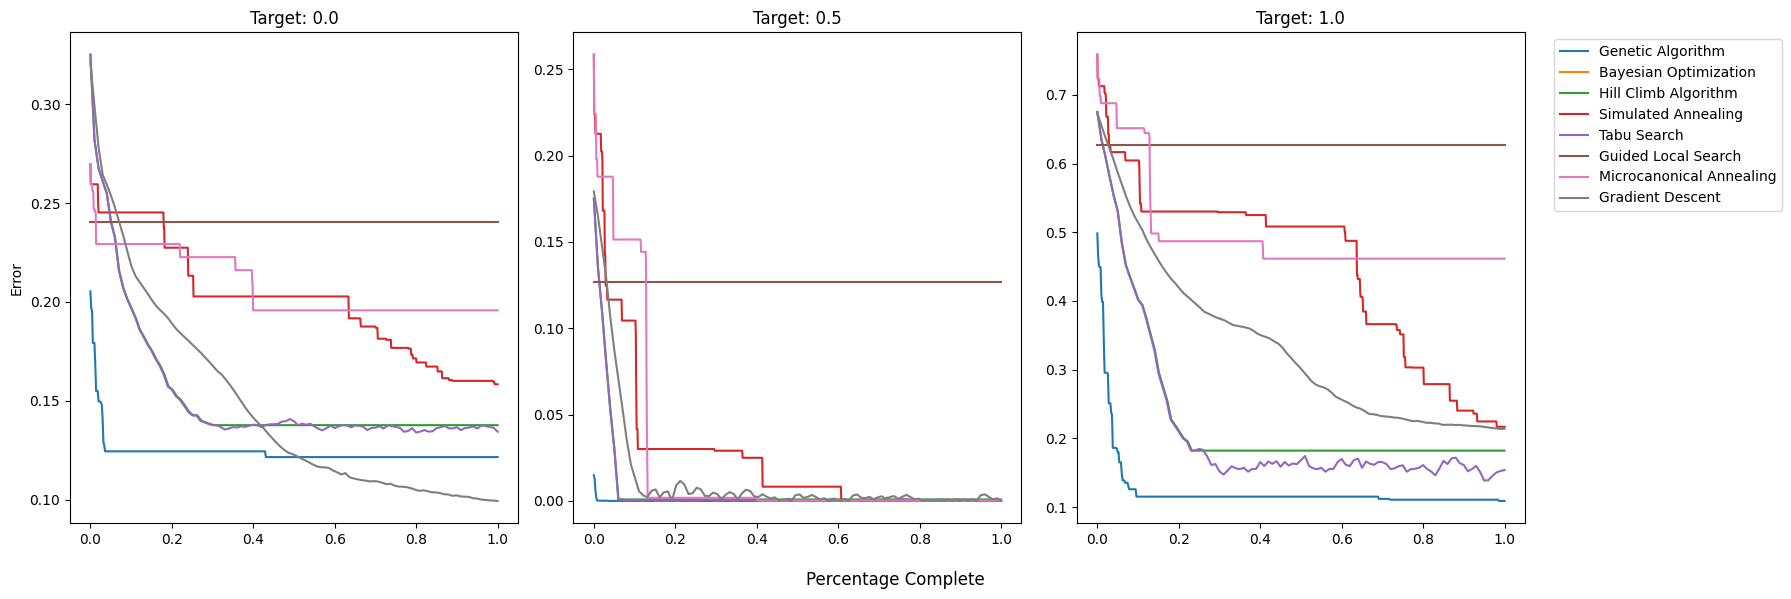

In [7]:
# -------------- Plot The Errors Over Time --------------

results_df = pd.DataFrame(results)
results_df = best_tests(results_df)

# Filter out Bayesian Optimization
results_df = results_df[results_df['optimizer'] != 'Bayesian Optimization']

df_exploded = results_df.explode('error_history').reset_index(drop=True)
df_exploded['error_history'] = df_exploded['error_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['error_history'].transform('count')
df_exploded['percentage_complete'] = df_exploded['iteration'] / (group_sizes - 1)

optimizer_names = optimizers.keys()
palette = sns.color_palette("tab10", len(optimizer_names))
color_map = dict(zip(optimizer_names, palette))

target_expressions = df_exploded['target_expression'].unique()
fig, axes = plt.subplots(1, len(target_expressions), figsize=(18, 6))

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['percentage_complete'],
                group['error_history'],
                color=color_map[optimizer],
                label=optimizer
            )
    ax.set_title(f'Target: {target_expr}')

axes[0].set_ylabel('Error')
fig.supxlabel("Percentage Complete")

handles = []
labels = []
for optimizer in optimizer_names:
    handles.append(plt.Line2D([], [], color=color_map[optimizer], label=optimizer))
    labels.append(optimizer)

handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


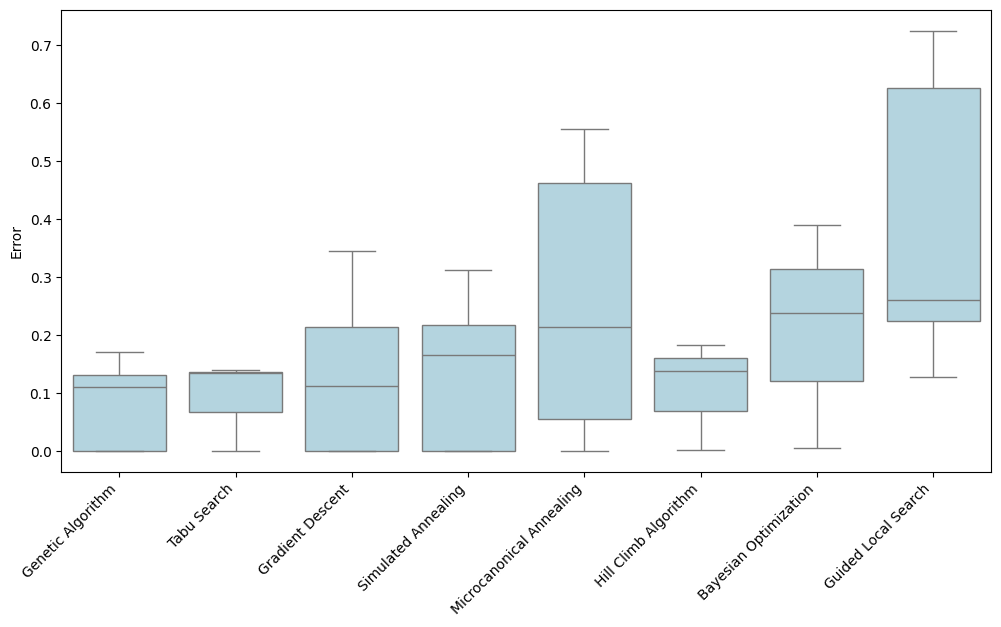

In [8]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df = results_df.sort_values(by='error')

# Plotting the error for each optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x='optimizer', y='error', data=results_df, color='lightblue',
            order=results_df['optimizer'].unique())
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.show()


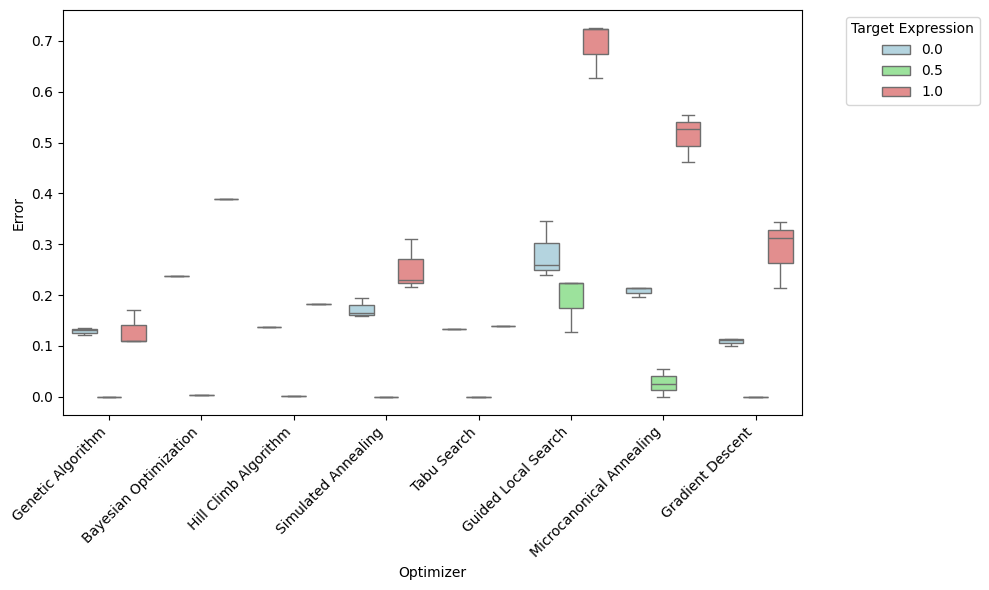

In [9]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='optimizer',
    y='error',
    hue='target_expression',
    data=results_df,
    palette=['lightblue', 'lightgreen', 'lightcoral'],
    showfliers=False
)
plt.xlabel('Optimizer')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
# plt.legend(title='Target Expression', loc='upper right')
plt.legend(title='Target Expression', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

In [10]:
results_df = pd.DataFrame(results)

sorted_df = results_df.sort_values(by='error')
min_error_preds = sorted_df.drop_duplicates(subset=['optimizer', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='prediction'
)

pivot_df.columns = [f'prediction (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=False)
pivot_df = pivot_df.reset_index()

pivot_df


,optimizer,prediction (target_expression=0.0),prediction (target_expression=0.5),prediction (target_expression=1.0)
0,Genetic Algorithm,0.121564,0.500000,0.891070
1,Tabu Search,0.133978,0.500005,0.861238
2,Hill Climb Algorithm,0.137703,0.499126,0.817831
3,Gradient Descent,0.099381,0.499993,0.786222
4,Simulated Annealing,0.158369,0.499992,0.783125
5,Bayesian Optimization,0.236981,0.504371,0.610389
6,Microcanonical Annealing,0.195752,0.500218,0.538490
7,Guided Local Search,0.240486,0.373430,0.373430


In [11]:
results_df = pd.DataFrame(results)
results_df = average_tests(results_df)[['optimizer', 'target_expression', 'prediction', 'error']]
results_df.head(None)

,optimizer,target_expression,prediction,error
0,Bayesian Optimization,0.0,0.236981,2.369810e-01
1,Bayesian Optimization,0.5,0.504371,4.370689e-03
2,Bayesian Optimization,1.0,0.610389,3.896109e-01
3,Genetic Algorithm,0.0,0.129520,1.295201e-01
4,Genetic Algorithm,0.5,0.500000,5.364418e-07
5,Genetic Algorithm,1.0,0.869879,1.301209e-01
6,Gradient Descent,0.0,0.108582,1.085824e-01
7,Gradient Descent,0.5,0.500007,1.192093e-05
8,Gradient Descent,1.0,0.709602,2.903981e-01
9,Guided Local Search,0.0,0.281806,2.818061e-01
